In [108]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [109]:
# Hyperparameters for this run
n_trials = 10000
test_stat="MLSnormal_positive"

In [110]:
def MLSnormal_oneside(bkg, sig):
    	return np.max((sig-bkg)/np.sqrt(bkg))

if test_stat=="MLSnormal_positive":
	test_stat_f = MLSnormal_oneside

In [111]:
#Load the mass spectra
data_path = "../../../DATA/LHCO/"
mjj_bg = np.load(data_path + "mjj_bkg_sort.npy")
mjj_sg = np.load(data_path + "mjj_sig_sort.npy")

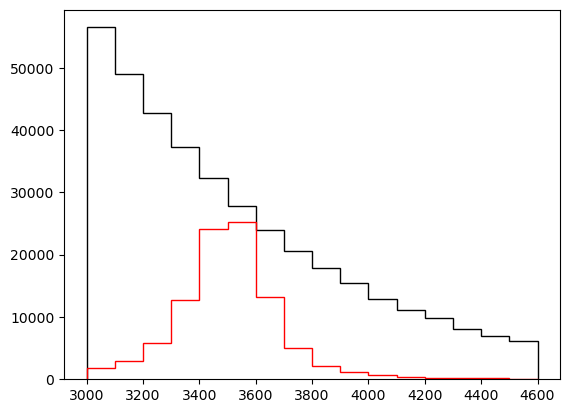

In [112]:
bkg = plt.hist(mjj_bg, bins=16, range=(3000, 4600), histtype="step", color="black")
bkg = bkg[0]
sig = plt.hist(mjj_sg, bins=16, range=(3000, 4600), histtype="step", color="red")
sig = sig[0]

In [113]:
x=np.linspace(3000, 4600, 17)
x=x[:-1]+(x[1]-x[0])/2

In [114]:
bkg_err = np.sqrt(bkg)
sig_err = np.sqrt(sig)

In [115]:
y_orig=bkg#+sig
y_orig_err=np.sqrt(bkg_err**2+sig_err**2)

In [116]:
fff = "4_param"
s=13000
def fit(x, y, y_err, fff, s=13000):
	if fff == "4_param":
		f = (
				lambda x, p1, p2, p3, p4: p1
				* (1 - x / s) ** p2
				* (x / s) ** p3
				* np.exp(p4 * np.log(x / s))
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[2.067e7, 1.368, 0.046, -0.087],
			bounds=(
				[0, -1000, -1000, -1000],
				[1000000000, 1000, 1000, 1000],
			),
		)
	elif fff == "3_param":
		f = (
				lambda x, p1, p2, p3: p1
				* (1 - x / s) ** p2
				* (x / s) ** p3
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[2.06e7, 1.36, -0.04],
			bounds=(
				[0, -1000, -1000],
				[1000000000, 1000, 1000],
			),
		)
	return rrr, f

rrr, f = fit(x, y_orig, y_orig_err, fff, s=13000)
fited = f(x, *rrr[0])
print(rrr)

(array([ 2.06818321e+06,  1.36817888e+01, -3.66535874e-01,  3.26062979e-01]), array([[ 1.18249246e+12,  6.83748558e+05, -1.04463346e+11,
         1.04463619e+11],
       [ 6.83748558e+05,  3.96311689e-01, -5.63684514e+04,
         5.63686085e+04],
       [-1.04463346e+11, -5.63684514e+04,  9.94082655e+10,
        -9.94082922e+10],
       [ 1.04463619e+11,  5.63686085e+04, -9.94082922e+10,
         9.94083189e+10]]))


1.4739690318959493
0.06661488181227045


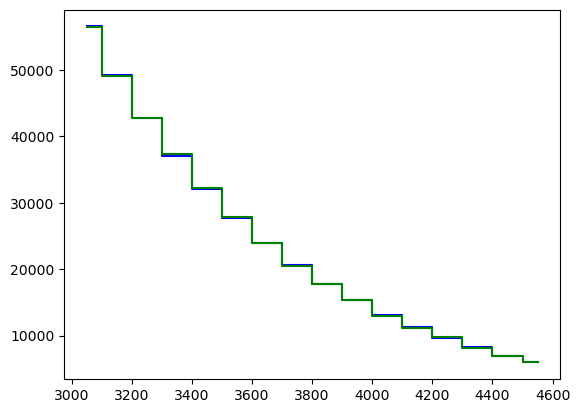

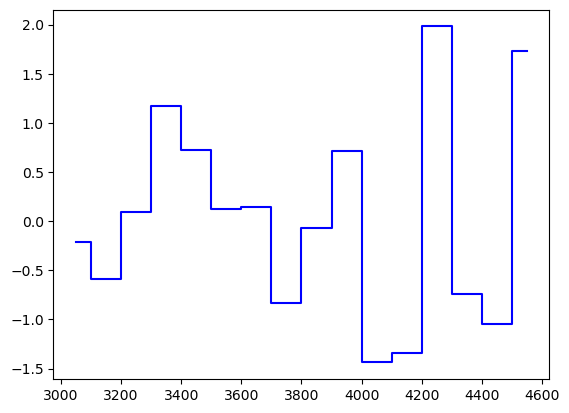

In [117]:
plt.step(x, fited, color="blue", where="mid")
plt.step(x, y_orig, color="green", where="mid")
plt.figure()
plt.step(x, (y_orig-fited)/y_orig_err, color="blue", where="mid")
print(MLSnormal_oneside(y_orig, fited))
k = len(y_orig)
print(np.sum((y_orig-fited)**2/y_orig_err**2)/(k*(k-1)))

In [118]:
test = np.max((y_orig-fited)**2/y_orig_err**2)
print(test)

3.923355806040564


In [119]:
def random_sampling(y, y_err):
    return np.random.normal(y, y_err)

In [120]:
def get_tests(y_orig, n_trials, signal=None):
    y_orig_err = np.sqrt(y_orig)
    tests=[]
    for i in range(n_trials):
        if signal is not None:
            y = random_sampling(y_orig, y_orig_err) + signal
        else:
            y = random_sampling(y_orig, y_orig_err)
        rrr, f = fit(x, y, y_orig_err, fff, s=13000)
        fited = f(x, *rrr[0])
        test = MLSnormal_oneside(fited, y)
        tests.append(test)
    return tests

tests_bg = get_tests(bkg, n_trials)

In [121]:
sig_fractions = [0.1, 0.075, 0.05, 0.025, 0.02, 0.015, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]
tests_sg_f = []
for sig_fraction in sig_fractions:
	sig_ = sig_fraction * sig
	tests_sg_f.append(get_tests(y_orig, 50, signal=sig_))

tests_sg_f = np.array(tests_sg_f)

In [122]:
import scipy.stats as stats
def p2Z(p):
    if isinstance(p, np.ndarray):
        out = []
        for one_p in p:
            out.append(-stats.norm.ppf(one_p))
        return np.array(out)
    elif isinstance(p, list):
        out = []
        for one_p in p:
            out.append(-stats.norm.ppf(one_p))
        return np.array(out)
    else:
        return -stats.norm.ppf(p)

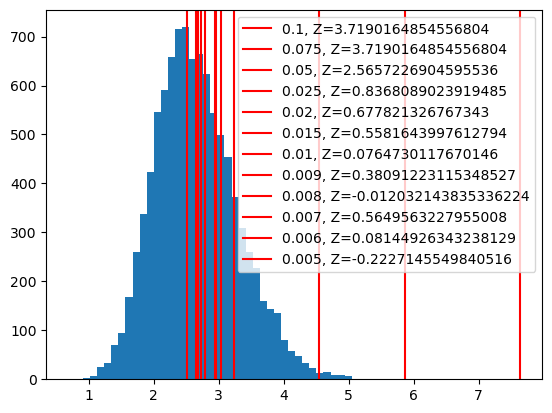

In [123]:
plt.hist(tests_bg, bins=50)
Zs = []
Zs_low = []
Zs_high = []
for i in range(len(sig_fractions)):
	ps = [1-np.mean(test>tests_bg) for test in tests_sg_f[i]]
	ps = np.array(ps)
	ps[ps==0]=1/n_trials
	Zs.append(p2Z(ps))
	plt.axvline(np.mean(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, Z={np.median(Zs[i])}")
	#plt.axvline(np.median(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, p={np.mean(np.median(tests_sg_f[i])>tests_bg)}")
plt.legend()

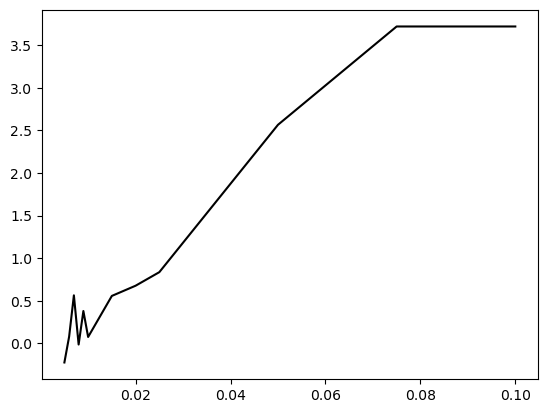

In [124]:
plt.plot(sig_fractions, [np.median(Zs_) for Zs_ in Zs], color="black")

In [125]:
import pickle
pickle.dump({"sig_fractions": np.array(sig_fractions), "Zs": np.array(Zs)}, open("Zs.pickle", "wb"))

In [126]:
np.array(sig_fractions)

array([0.1  , 0.075, 0.05 , 0.025, 0.02 , 0.015, 0.01 , 0.009, 0.008,
       0.007, 0.006, 0.005])

In [127]:
np.array(Zs)

array([[ 3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00,  3.71901649e+00,
         3.71901649e+00,  3.71901649e+00],
       [ 3.54

In [128]:
np.array(sig_fractions) * len(mjj_sg)

array([10000.,  7500.,  5000.,  2500.,  2000.,  1500.,  1000.,   900.,
         800.,   700.,   600.,   500.])

Now make everything Idealised 

In [129]:
def get_tests(y_orig, n_trials, signal=None):
    y_orig_err = np.sqrt(y_orig)
    tests=[]
    for i in range(n_trials):
        if signal is not None:
            y = random_sampling(y_orig, y_orig_err) + signal
        else:
            y = random_sampling(y_orig, y_orig_err)
        test = MLSnormal_oneside(y_orig, y)
        tests.append(test)
    return tests

tests_bg = get_tests(bkg, n_trials)


In [130]:
sig_fractions = [0.1, 0.075, 0.05, 0.025, 0.02, 0.015, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]
tests_sg_f = []
for sig_fraction in sig_fractions:
	sig_ = sig_fraction * sig
	tests_sg_f.append(get_tests(y_orig, 50, signal=sig_))

tests_sg_f = np.array(tests_sg_f)

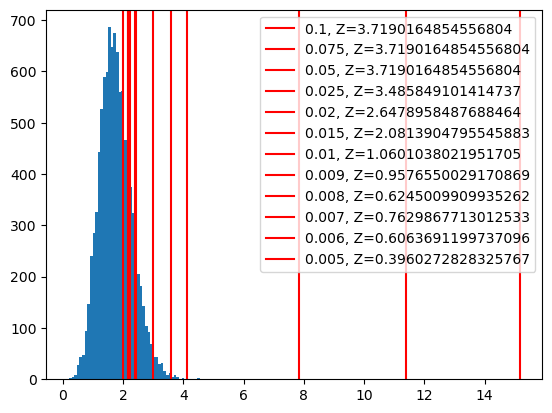

In [131]:
plt.hist(tests_bg, bins=50)
Zs = []
Zs_low = []
Zs_high = []
for i in range(len(sig_fractions)):
	ps = [1-np.mean(test>tests_bg) for test in tests_sg_f[i]]
	ps = np.array(ps)
	ps[ps==0]=1/n_trials
	Zs.append(p2Z(ps))
	plt.axvline(np.mean(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, Z={np.median(Zs[i])}")
	#plt.axvline(np.median(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, p={np.mean(np.median(tests_sg_f[i])>tests_bg)}")
plt.legend()

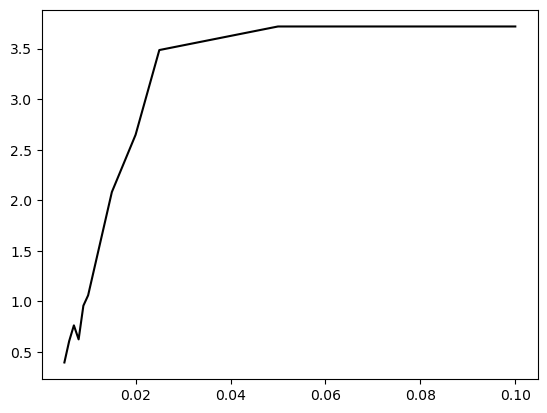

In [132]:
plt.plot(sig_fractions, [np.median(Zs_) for Zs_ in Zs], color="black")

In [133]:
import pickle
pickle.dump({"sig_fractions": np.array(sig_fractions), "Zs": np.array(Zs)}, open("Zs_ideal.pickle", "wb"))